# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.__version__

'2.2.2'

In [3]:
%matplotlib inline

In [4]:
from pathlib import Path
import numpy as np

In [5]:
import torch
import torchvision

In [6]:
torch.__version__, torchvision.__version__

('1.0.0', '0.2.1')

In [7]:
imagenet_stats = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}
imagenet_stats

{'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

# Load Data

In [8]:
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.optim as optim
import torch.nn as nn

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
import json
with open('cat_to_name.json') as f:
    cat_to_name = json.load(f)

In [11]:
data_path = Path('flower_data')

In [14]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=45, shear=(10, 10), translate=(.0, .10), scale=(1.0, 1.2)),
#         transforms.ColorJitter(brightness=0.3),
#         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize(256),
    transforms.RandomCrop(224),
#         transforms.RandomResizedCrop(),
    transforms.ToTensor(),
    transforms.Normalize(**imagenet_stats)
])

train_transform_basic = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(**imagenet_stats)
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(**imagenet_stats)
])

valid_transform_tta = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize(**imagenet_stats)(transforms.ToTensor()(crop))
        for crop in crops]))
])

# Train Model

### Fastai tricks

In [18]:
from flowers.fastai_tricks import *
from flowers.schedules import *
from flowers.adamw import *

### Create, Save, Load Model

In [19]:
from flowers.model import *

### Train model

In [20]:
def train_loop(dataloaders, model, criterion, optimizer, scheduler, epochs):
    since = time.time()

    best_model_wts = None
    best_acc = 0.0
    best_loss = 100

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)

        for phase in dataloaders.keys():
            if phase == 'train':
                model.train()
                if hasattr(scheduler, 'step'):
                    scheduler.step()
            else:
                model.eval()
            running_loss, running_corrects = 0.0, 0.0

            for inputs, labels in dataloaders[phase]:
                print('.', end='')
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                    else:
                        ns, ncrops, c, h, w = inputs.size()
                        outputs = model(inputs.view(-1, c, h, w))
                        outputs_avg = outputs.view(ns, ncrops, -1).mean(1)
                        _, preds = torch.max(outputs_avg, 1)
                        loss = criterion(outputs_avg, labels)

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()

                if phase == 'train' and hasattr(scheduler, 'batch_step'):
                    scheduler.batch_step()
            print()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}, Best val Acc: {:4f}'.format(best_loss, best_acc))

    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [21]:
datasets = {
    'train': torchvision.datasets.ImageFolder(root=str(data_path/'train'), transform=train_transform),
    'valid': torchvision.datasets.ImageFolder(root=str(data_path/'valid'), transform=valid_transform_tta)
}

In [22]:
batch_size = 48
num_workers = 4
dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers),
    'valid': torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)
}

In [23]:
# input_iter = iter(dataloaders['train'])
# plot_inputs(3, 5, input_iter)

In [24]:
# model = load_model(arch, 'resnet34-stage2.pth')
# freeze(model[0])

In [26]:
arch = models.resnet34

In [30]:
epochs = 3
lr_max = 3e-3
weight_decay = 5e-2

In [31]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-1,
#                      step_size=step_size, mode='triangular2', debug=False)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = WarmRestartsLR(optimizer, lr_min=1e-4, lr_max=1e-2, T=50, T_mult=2)
model = create_model(arch, device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=0.01, betas=(0.9, 0.99), weight_decay=weight_decay)
scheduler = OneCycleScheduler(optimizer, lr_max=lr_max,
                              batches=len(dataloaders['train']), epochs=epochs, debug=False)
criterion = nn.CrossEntropyLoss()

In [32]:
model, best_loss, best_acc = train_loop(dataloaders, model, criterion, optimizer, scheduler,
                                        epochs=epochs)

Epoch 1/3
----------
.........................................................................................................................................
train Loss: 3.1069 Acc: 0.3385
..................
valid Loss: 0.6397 Acc: 0.8778

Epoch 2/3
----------
.........................................................................................................................................
train Loss: 0.8014 Acc: 0.7908
..................
valid Loss: 0.3073 Acc: 0.9364

Epoch 3/3
----------
.........................................................................................................................................
train Loss: 0.5096 Acc: 0.8675
..................
valid Loss: 0.2626 Acc: 0.9499

Training complete in 1m 33s
Best val Loss: 0.262621, Best val Acc: 0.949878


In [33]:
save_model(model, 'resnet-stage1.pth')

In [34]:
# Fine-tuning

In [35]:
batch_size = 64
num_workers = 4
dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers),
    'valid': torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)
}

In [36]:
epochs = 5
weight_decay = 2e-4
lr_max = 7e-5

In [38]:
model = load_model(arch, device, 'resnet-stage1.pth')
unfreeze(model)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=0.01, betas=(0.9, 0.99), weight_decay=weight_decay)
scheduler = OneCycleScheduler(optimizer, lr_max=lr_max,
                              batches=len(dataloaders['train']), epochs=epochs, debug=False)
criterion = nn.CrossEntropyLoss()

In [39]:
model, best_loss, best_acc = train_loop(dataloaders, model, criterion, optimizer, scheduler,
                                        epochs=epochs)

Epoch 1/5
----------
.......................................................................................................
train Loss: 0.3996 Acc: 0.8985
.............
valid Loss: 0.1891 Acc: 0.9621

Epoch 2/5
----------
.......................................................................................................
train Loss: 0.2487 Acc: 0.9380
.............
valid Loss: 0.1565 Acc: 0.9633

Epoch 3/5
----------
.......................................................................................................
train Loss: 0.1679 Acc: 0.9582
.............
valid Loss: 0.1141 Acc: 0.9817

Epoch 4/5
----------
.......................................................................................................
train Loss: 0.1239 Acc: 0.9722
.............
valid Loss: 0.0942 Acc: 0.9853

Epoch 5/5
----------
.......................................................................................................
train Loss: 0.0929 Acc: 0.9818
.............
valid Loss: 0.0908 Acc

In [40]:
save_model(model, 'resnet-stage2.pth', class_to_idx=datasets['train'].class_to_idx)

In [ ]:
# "Polishing" with simple augs

In [34]:
datasets = {
    'train': torchvision.datasets.ImageFolder(root=str(data_path/'train'), transform=train_transform_basic),
    'valid': torchvision.datasets.ImageFolder(root=str(data_path/'valid'), transform=valid_transform_tta)
}
batch_size = 64
num_workers = 4
dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers),
    'valid': torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)
}

In [35]:
epochs = 15
weight_decay = 1e-3
lr_max = 1e-5

In [36]:
model = load_model(models.resnet101, 'resnet-stage2.pth')
unfreeze(model)
# optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
#                   lr=0.01, betas=(0.9, 0.99), weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=lr_max, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
# scheduler = OneCycleScheduler(optimizer, lr_max=lr_max,
#                               batches=len(dataloaders['train']), epochs=epochs, debug=False)
criterion = nn.CrossEntropyLoss()

In [37]:
model, best_loss, best_acc = train_loop(dataloaders, model, criterion, optimizer, scheduler,
                                        epochs=epochs)

Epoch 1/15
----------
.......................................................................................................
train Loss: 0.0071 Acc: 0.9988
.............
valid Loss: 0.0534 Acc: 0.9914

Epoch 2/15
----------
.......................................................................................................
train Loss: 0.0075 Acc: 0.9980
.............
valid Loss: 0.0566 Acc: 0.9890

Epoch 3/15
----------
.......................................................................................................
train Loss: 0.0084 Acc: 0.9979
.............
valid Loss: 0.0572 Acc: 0.9890

Epoch 4/15
----------
.......................................................................................................
train Loss: 0.0062 Acc: 0.9989
.............
valid Loss: 0.0549 Acc: 0.9914

Epoch 5/15
----------
.......................................................................................................
train Loss: 0.0070 Acc: 0.9986
.............
valid Loss: 0.055

In [57]:
# Final Validation

In [52]:
datasets = {
    'valid': torchvision.datasets.ImageFolder(root=str(data_path/'valid'), transform=valid_transform)
}
batch_size = 64
num_workers = 4
dataloaders = {
    'valid': torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)
}

In [56]:
running_loss, running_corrects = 0.0, 0.0
for inputs, labels in dataloaders['valid']:
    print('.', end='')
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    with torch.set_grad_enabled(False):
        if len(inputs.size()) > 4:
            ns, ncrops, c, h, w = inputs.size()
            outputs = model(inputs.view(-1, c, h, w))
            outputs = outputs.view(ns, ncrops, -1).mean(1)
            _, preds = torch.max(outputs, 1)
        else:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

epoch_loss = running_loss / len(dataloaders['valid'].dataset)
epoch_acc = running_corrects / len(dataloaders['valid'].dataset)
print(f'\nValid Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

.............
Valid Loss: 0.0711 Acc: 0.9866


# Hyperopt Experiments

In [107]:
import pickle
import time
import random
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials

In [108]:
datasets = {
    'train': torchvision.datasets.ImageFolder(root=str(data_path/'train'), transform=train_transform),
    'valid': torchvision.datasets.ImageFolder(root=str(data_path/'valid'), transform=valid_transform_tta)
}

def objective(params):
    try:
        print(params)
        start = time.time()
        batch_size = int(params['batch_size'])
        dataloaders = {
            'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size,
                                                 shuffle=True, num_workers=4),
            'valid': torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_size,
                                                 shuffle=False, num_workers=4)
        }
        epochs = 15
#         model = create_model(params['arch'])
        model = load_model(arch, 'resnet-stage1.pth')
        unfreeze(model)
        optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=0.01, betas=(0.9, 0.99), weight_decay=params['weight_decay'])
        scheduler = OneCycleScheduler(optimizer, lr_max=params['lr_max'],
                                      batches=len(dataloaders['train']), epochs=epochs, debug=False)
        criterion = nn.CrossEntropyLoss()
        model, best_loss, best_acc = train_loop(dataloaders, model, criterion, optimizer, scheduler,
                                                epochs=epochs)
        res = {
            'loss': best_loss,
            'acc': best_acc,
            'status': STATUS_OK,
            'time': time.time() - start
        }
    except KeyboardInterrupt as e:
        raise
    except BaseException as e:
        print(e)
        res = {
            'loss': 100,
            'acc': 0,
            'status': STATUS_FAIL,
            'time': time.time() - start
        }
    finally:
        if model:
            model.to('cpu')
        torch.cuda.empty_cache()
        print(res)
        params.update(res)
        return params

In [110]:
space = {
    'batch_size': hp.choice('batch_size', np.arange(16, 256, 16, dtype=int)),
    'lr_max': hp.loguniform('lr_max', np.log(1e-5), np.log(1e-2)),
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-6), np.log(1)),
#     'arch': hp.choice('arch', [models.resnet34, models.resnet50, models.resnet101]),
}

In [45]:
trials = Trials()
best = fmin(objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

In [112]:
import pandas as pd
trials_df = pd.DataFrame(trials.results)
trials_df.to_csv('trials-stage2.csv', sep='\t', index=False)

In [38]:
# trials_df = pd.read_csv('trials-stage1.csv', sep='\t')

In [44]:
# trials_df.sort_values(by='status')

In [115]:
trials_df.sort_values(by='acc', ascending=False)

,acc,batch_size,loss,lr_max,status,time,weight_decay
21,0.995110,48,0.056657,0.000038,ok,804.644610,0.000001
41,0.995110,64,0.050929,0.000073,ok,785.925107,0.000272
26,0.993888,64,0.057410,0.000025,ok,783.253139,0.459626
23,0.992665,48,0.058264,0.000044,ok,803.678368,0.000044
40,0.992665,64,0.054839,0.000074,ok,785.247967,0.000212
36,0.992665,32,0.055512,0.000026,ok,853.277575,0.000018
31,0.991443,48,0.062161,0.000136,ok,803.593891,0.000194
24,0.991443,48,0.055415,0.000041,ok,807.265188,0.972279
44,0.990220,64,0.057395,0.000078,ok,785.528910,0.003478
30,0.988998,48,0.059515,0.000014,ok,803.917024,0.148601


In [116]:
# trials_df['arch_name'] = trials_df.arch.map(lambda a: a.__name__)
# trials_df.to_csv('trials.csv', sep='\t', index=False)

In [122]:
import seaborn as sns
sns.set(style="whitegrid")
sns.__version__

'0.9.0'

In [132]:
df = trials_df[trials_df.acc > 0.85]

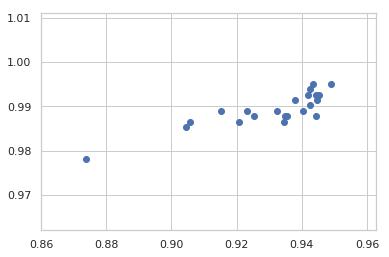

In [133]:
plt.scatter(1 - df.loss.values, df.acc.values)

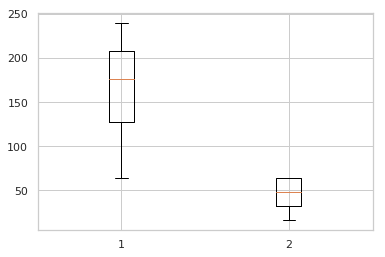

In [134]:
fig, ax = plt.subplots()
data = [trials_df[trials_df.status == 'fail'].batch_size.values,
        trials_df[trials_df.status == 'ok'].batch_size.values]
ax.boxplot(data);

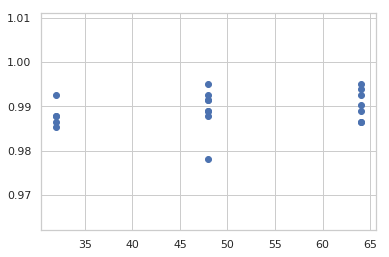

In [136]:
fig, ax = plt.subplots()
df = trials_df
df = df[(df.status == 'ok')&(df.batch_size < 100)&(df.batch_size > 20)]
ax.scatter(df.batch_size.values, df.acc.values)

In [204]:
df = trials_df.copy()
df['arch_name'] = df.arch.map(lambda a: a.__name__)

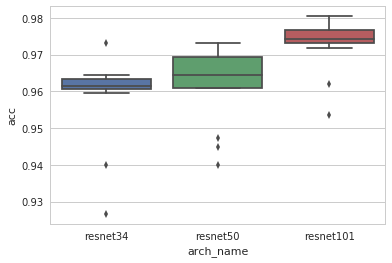

In [217]:
df = df[df.acc > 0.8]
ax = sns.boxplot(x=df.arch_name, y=df.acc)

In [144]:
df = trials_df.copy()
df['acc_loss'] = df.acc * (1 - df.loss)
df = df[df.acc > 0.95]
# df = df[df.arch_name == 'resnet101']
df.sort_values(by='acc_loss', ascending=False)

,acc,batch_size,loss,lr_max,status,time,weight_decay,acc_loss
41,0.995110,64,0.050929,0.000073,ok,785.925107,0.000272,0.944430
21,0.995110,48,0.056657,0.000038,ok,804.644610,0.000001,0.938730
40,0.992665,64,0.054839,0.000074,ok,785.247967,0.000212,0.938229
36,0.992665,32,0.055512,0.000026,ok,853.277575,0.000018,0.937560
26,0.993888,64,0.057410,0.000025,ok,783.253139,0.459626,0.936829
24,0.991443,48,0.055415,0.000041,ok,807.265188,0.972279,0.936502
23,0.992665,48,0.058264,0.000044,ok,803.678368,0.000044,0.934829
44,0.990220,64,0.057395,0.000078,ok,785.528910,0.003478,0.933386
37,0.987775,32,0.055611,0.000018,ok,855.304644,0.000061,0.932844
30,0.988998,48,0.059515,0.000014,ok,803.917024,0.148601,0.930138


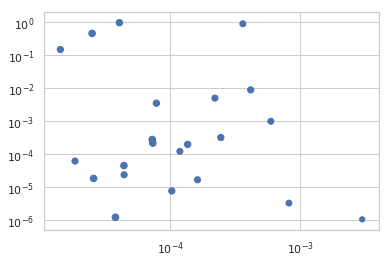

In [149]:
plt.subplot()
plt.xscale('log')
plt.yscale('log')
plt.minorticks_on()
plt.scatter(x=df.lr_max.values, y=df.weight_decay.values, s=(df.acc.values - 0.95)*1000)

# TTA Experiments

In [110]:
tta_probs_all = []
tta_labels_all = []

model.eval()
running_loss, running_corrects = 0.0, 0.0
dataloaders = load_data(batch_size=64, tta=True)
for inputs, labels in dataloaders['valid']:
    print('.', end='')
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.set_grad_enabled(False):
        ns, ncrops, c, h, w = inputs.size()
        outputs = model(inputs.view(-1, c, h, w))
        outputs_avg = outputs.view(ns, ncrops, -1).mean(1)
        _, preds = torch.max(outputs_avg, 1)
        loss = criterion(outputs_avg, labels)
        
        tta_probs_all.append(outputs_avg.cpu().numpy())
        tta_labels_all.append(labels.cpu().numpy())

        running_loss += loss.item() * ns
        running_corrects += torch.sum(preds == labels.data).cpu().numpy()

tta_probs_all = np.concatenate(tta_probs_all)
tta_labels_all = np.concatenate(tta_labels_all)
        
epoch_loss = running_loss / len(dataloaders['valid'].dataset)
epoch_acc = running_corrects / len(dataloaders['valid'].dataset)
epoch_loss, epoch_acc

.............

(0.0782444745229334, 0.9865525672371638)

In [83]:
# np.concatenate(avg_preds_all),
# np.concatenate(labels_all)

In [111]:
probs_all = []
labels_all = []

model.eval()
running_loss, running_corrects = 0.0, 0.0
dataloaders = load_data(batch_size=64, tta=False)
for inputs, labels in dataloaders['valid']:
    print('.', end='')
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.set_grad_enabled(False):
        outputs = model(inputs.view(-1, c, h, w))
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        probs_all.append(outputs)
        labels_all.append(labels)

        running_loss += loss.item() * ns
        running_corrects += torch.sum(preds == labels.data).cpu().numpy()

probs_all = np.concatenate(probs_all)
labels_all = np.concatenate(labels_all)
        
epoch_loss = running_loss / len(dataloaders['valid'].dataset)
epoch_acc = running_corrects / len(dataloaders['valid'].dataset)
epoch_loss, epoch_acc

.............

(0.07271976198791583, 0.9816625916870416)

In [121]:
for beta in np.linspace(0, 1, 11):
    comb_probs = beta * tta_probs_all + (1 - beta) * probs_all
    corrects = (comb_probs.argmax(axis=1) == labels_all)
    print(beta, corrects.sum(), corrects.mean())

0.0 803 0.9816625916870416
0.1 804 0.9828850855745721
0.2 806 0.9853300733496333
0.30000000000000004 806 0.9853300733496333
0.4 805 0.9841075794621027
0.5 805 0.9841075794621027
0.6000000000000001 806 0.9853300733496333
0.7000000000000001 806 0.9853300733496333
0.8 807 0.9865525672371638
0.9 807 0.9865525672371638
1.0 807 0.9865525672371638


In [127]:
a = np.asarray(list(zip(tta_probs_all.argmax(axis=1), probs_all.argmax(axis=1), labels_all)))

In [131]:
a[~((a[:,0] == a[:,2]) | (a[:,0] == a[:,2]))]

array([[ 66,  66,  13],
       [ 28,  28,  26],
       [ 13,  25,  36],
       [ 64,  64,  47],
       [ 52,  47,  47],
       [ 28,  28,  51],
       [ 75,  75,  69],
       [ 28,  28,  76],
       [ 96,  96,  95],
       [ 99,  99,  98],
       [ 24,  24, 101]])

# Cross Validation Model Training

In [41]:
from flowers.dataset import *

In [36]:
train_valid_ds = TrainValidListDataset(data_path, 'train', 'valid')

In [46]:
from sklearn.model_selection import KFold
np.random.seed(13)

arch = models.resnet101

cv_results = []
cv = KFold(n_splits=5, shuffle=True)
for i, (train_inds, valid_inds) in enumerate(cv.split(train_valid_ds)):
    datasets = {
        'train': SubsetDataset(train_valid_ds, train_inds, train_transform),
        'valid': SubsetDataset(train_valid_ds, valid_inds, valid_transform_tta)
    }
    print(f'Fold: {i}', len(datasets['train']), len(datasets['valid']))
    batch_size = 48
    num_workers = 4
    dataloaders = {
        'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers),
        'valid': torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
    }
    epochs = 15
    lr_max = 3e-3
    weight_decay = 5e-2
    
    model = create_model(arch)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=0.01, betas=(0.9, 0.99), weight_decay=weight_decay)
    scheduler = OneCycleScheduler(optimizer, lr_max=lr_max,
                                  batches=len(dataloaders['train']), epochs=epochs, debug=False)                  
    criterion = nn.CrossEntropyLoss()
    model, best_loss_head, best_acc_head = train_loop(dataloaders, model, criterion, optimizer, scheduler,
                                                      epochs=epochs)
    
    batch_size = 64
    num_workers = 4
    dataloaders = {
        'train': torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers),
        'valid': torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
    }
    epochs = 15
    lr_max = 7e-5
    weight_decay = 2e-4
    
    unfreeze(model)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=0.01, betas=(0.9, 0.99), weight_decay=weight_decay)
    scheduler = OneCycleScheduler(optimizer, lr_max=lr_max,
                                  batches=len(dataloaders['train']), epochs=epochs, debug=False)
    criterion = nn.CrossEntropyLoss()
    model, best_loss, best_acc = train_loop(dataloaders, model, criterion, optimizer, scheduler,
                                            epochs=epochs)
    
    model_path = f'resnet-cv-{i}.pth'
    save_model(model, model_path)
    
    d = {
        'model_path': model_path,
        'best_loss_head': best_loss_head,
        'best_acc_head': best_acc_head,
        'best_loss': best_loss,
        'best_acc': best_acc
    }
    cv_results.append(d)
    print(f'Results: {d}')

In [39]:
import pandas as pd
cv_results_df = pd.DataFrame(cv_results)
cv_results_df

,best_acc,best_acc_head,best_loss,best_loss_head,model_path
0,0.993216,0.969471,0.038495,0.112781,resnet-cv-0.pth
1,0.993894,0.971506,0.043253,0.123707,resnet-cv-1.pth
2,0.981004,0.965400,0.082509,0.146316,resnet-cv-2.pth
3,0.986431,0.964043,0.073682,0.140441,resnet-cv-3.pth
4,0.987788,0.976255,0.059606,0.115909,resnet-cv-4.pth


In [42]:
# test_ds = torchvision.datasets.ImageFolder(root=str(data_path / 'test'), transform=valid_transform_tta)
# test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# Predict and Submit Test Set

In [97]:
n = 818
for i in range(20):
    print(i, (n - i) / n)

0 1.0
1 0.9987775061124694
2 0.9975550122249389
3 0.9963325183374083
4 0.9951100244498777
5 0.9938875305623472
6 0.9926650366748166
7 0.991442542787286
8 0.9902200488997555
9 0.988997555012225
10 0.9877750611246944
11 0.9865525672371638
12 0.9853300733496333
13 0.9841075794621027
14 0.9828850855745721
15 0.9816625916870416
16 0.980440097799511
17 0.9792176039119804
18 0.9779951100244498
19 0.9767726161369193


In [58]:
from flowers.test_predict import *

In [60]:
test_ds = torchvision.datasets.ImageFolder(root=str(data_path / 'test'), transform=valid_transform_tta)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)
test_preds = predict_test(test_dl, model)
# test_preds = ensemble_predict_test(models.resnet101, test_dl, [f'resnet-cv-{i}.pth' for i in range(5)])

.............

In [63]:
idx_to_class = {v: k for k, v in dataloaders['valid'].dataset.class_to_idx.items()}

In [64]:
create_submission(test_preds, idx_to_class, fn='submission.csv')

Saved to file: submission.csv


In [44]:
# !ls -lah |grep submission

In [43]:
# !kaggle competitions submit oxford-102-flower-pytorch -f submission.csv\
#  -m "resnet101, 15 epochs, bs 48/64, 1cycle + other fastai tricks, lr=3e-3/7e-5, AdamW wd=5e-2/2e-4, basic affine aug, 45 rot, 10xTTA, retrained"